In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Set up paths
current_dir = os.path.dirname(os.path.abspath('__file__'))
project_root = os.path.dirname(os.path.dirname(current_dir))
data_path = os.path.join(project_root, "data", "madden_data_processed.xlsx")

# Load the Madden team data
print(f"Loading data from: {data_path}")
try:
    madden_data = pd.read_excel(data_path)
    print(f"Successfully loaded data with {madden_data.shape[0]} rows and {madden_data.shape[1]} columns")
    
    # Display the first few rows of the dataset
    display(madden_data.head())
    
    # Basic information about the dataset
    print("\nDataset Information:")
    print(f"Number of teams: {madden_data.shape[0]}")
    print(f"Number of features: {madden_data.shape[1]}")
    
    # Check for missing values
    missing_values = madden_data.isnull().sum()
    if missing_values.sum() > 0:
        print("\nMissing values in the dataset:")
        print(missing_values[missing_values > 0])
    else:
        print("\nNo missing values in the dataset.")
        
except FileNotFoundError:
    print(f"Error: The file {data_path} was not found.")
    print("Please ensure the data file exists at the specified location.")
except Exception as e:
    print(f"Error loading data: {str(e)}")


Loading data from: /Users/ryanbergmac/Desktop/Master Plan/AI-Masters/SP25 - Applied Game Theory/rb-game-theory/data/madden_data_processed.xlsx
Successfully loaded data with 288 rows and 154 columns


,C1,C2,C3,C4,C5,C6,CB1,CB2,CB3,CB4,...,WR9,WR10,WR11,WR12,WR13,team_name,year,regular_season_wins,playoff_wins,total_wins
0,79,61,0,0,0,0,90,83,76,73,...,0,0,0,0,0,Buffalo Bills,2024,13,0,13
1,84,66,0,0,0,0,87,87,76,74,...,68,0,0,0,0,New England Patriots,2019,12,0,12
2,88,64,0,0,0,0,80,79,73,70,...,63,0,0,0,0,Carolina Panthers,2020,5,0,5
3,90,63,0,0,0,0,86,82,75,74,...,0,0,0,0,0,Las Vegas Raiders,2018,4,0,4
4,81,72,54,0,0,0,85,83,76,74,...,66,60,0,0,0,Buffalo Bills,2017,9,0,9



Dataset Information:
Number of teams: 288
Number of features: 154

No missing values in the dataset.


Preparing data for modeling...

Fold 1:
Testing on 58 teams
  Green Bay Packers (2023): Predicted wins: 9.9, Actual wins: 9
  Tampa Bay Buccaneers (2015): Predicted wins: 8.3, Actual wins: 6
  San Francisco 49ers (2016): Predicted wins: 7.7, Actual wins: 2
  Minnesota Vikings (2021): Predicted wins: 8.0, Actual wins: 8
  Seattle Seahawks (2024): Predicted wins: 7.0, Actual wins: 10

Fold 2:
Testing on 58 teams
  Atlanta Falcons (2021): Predicted wins: 7.5, Actual wins: 7
  Tennessee Titans (2019): Predicted wins: 7.2, Actual wins: 9
  Green Bay Packers (2019): Predicted wins: 9.2, Actual wins: 13
  Cincinnati Bengals (2018): Predicted wins: 7.6, Actual wins: 6
  Cincinnati Bengals (2021): Predicted wins: 6.7, Actual wins: 10

Fold 3:
Testing on 58 teams
  Buffalo Bills (2024): Predicted wins: 10.7, Actual wins: 13
  Carolina Panthers (2020): Predicted wins: 9.2, Actual wins: 5
  Buffalo Bills (2018): Predicted wins: 7.6, Actual wins: 6
  Las Vegas Raiders (2016): Predicted wins: 8.2, A

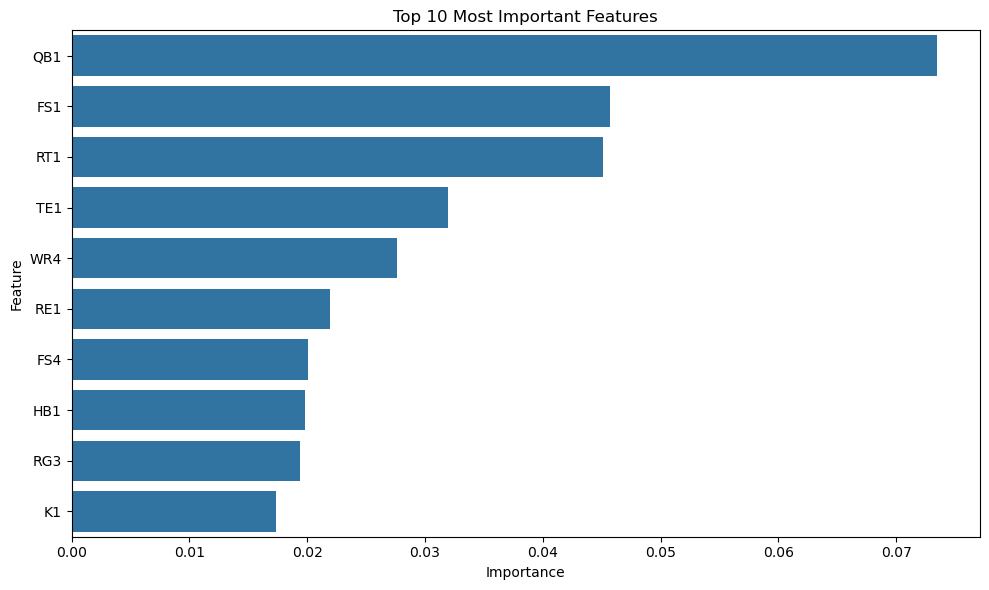

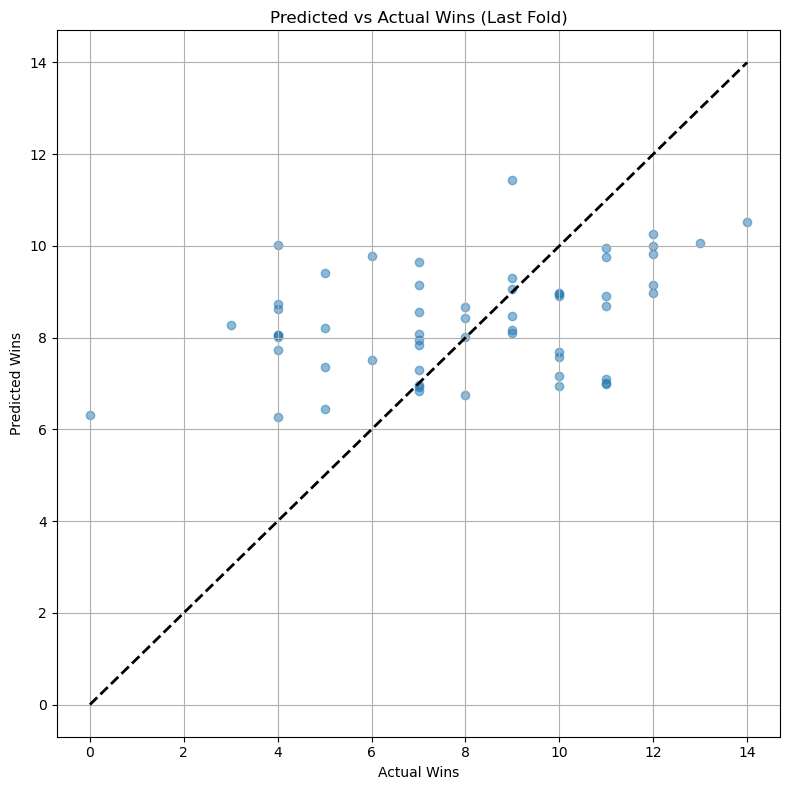

In [23]:
# Prepare the data for modeling
print("Preparing data for modeling...")

# Define features and target
X = madden_data.drop(['team_name', 'year', 'regular_season_wins', 'playoff_wins', 'total_wins'], axis=1)
y = madden_data['total_wins']

# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Initialize StandardScaler
scaler = StandardScaler()

# Perform 5-fold cross-validation
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold = 1
results = []

for train_index, test_index in kf.split(X):
    print(f"\nFold {fold}:")
    
    # Split the data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Scale the features
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train the model
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Store results
    results.append({
        'fold': fold,
        'mse': mse,
        'rmse': rmse,
        'r2': r2
    })
    
    # Display some test examples
    test_examples = madden_data.iloc[test_index]
    print(f"Testing on {len(test_examples)} teams")
    
    # Display 5 examples (or fewer if test set is smaller)
    num_examples = min(5, len(test_examples))
    for i in range(num_examples):
        team = test_examples.iloc[i]
        idx = test_index[i]
        print(f"  {team['team_name']} ({team['year']}): Predicted wins: {y_pred[i]:.1f}, Actual wins: {team['total_wins']}")
    
    fold += 1

# Summarize cross-validation results
print("\nCross-validation results summary:")
avg_mse = np.mean([r['mse'] for r in results])
avg_rmse = np.mean([r['rmse'] for r in results])
avg_r2 = np.mean([r['r2'] for r in results])

print(f"Average MSE: {avg_mse:.4f}")
print(f"Average RMSE: {avg_rmse:.4f}")
print(f"Average R²: {avg_r2:.4f}")

# Feature importance
print("\nTop 10 most important features:")
feature_importances = model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values('Importance', ascending=False).head(10)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Top 10 Most Important Features')
plt.tight_layout()
plt.show()

# Scatter plot of predicted vs actual wins
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Wins')
plt.ylabel('Predicted Wins')
plt.title('Predicted vs Actual Wins (Last Fold)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [36]:
# Neural Network Regressor Model with PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("\n\n--- PyTorch Neural Network Regression Model ---\n")

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the neural network model
class NeuralNetworkRegressor(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetworkRegressor, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 1)
        self.leaky_relu = nn.LeakyReLU(0.1)

    def forward(self, x):
        x = self.leaky_relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.leaky_relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.leaky_relu(self.fc3(x))
        x = self.leaky_relu(self.fc4(x))
        x = self.fc5(x)
        return x

# Prepare data - keep team_name and year for debugging but don't use them as features
X_with_metadata = madden_data.drop(['regular_season_wins', 'playoff_wins', 'total_wins'], axis=1)
y = madden_data['total_wins']

# Normalize win values to [0,1] range for training
y_min = y.min()
y_max = y.max()
y_normalized = (y - y_min) / (y_max - y_min)

# Initialize K-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
results = []

# For storing all predictions
all_y_test = []
all_y_pred = []
all_team_metadata = []

for train_index, test_index in kf.split(X_with_metadata):
    print(f"\nFold {fold}:")
    
    # Split data
    X_train_with_metadata = X_with_metadata.iloc[train_index]
    X_test_with_metadata = X_with_metadata.iloc[test_index]
    y_train = y_normalized.iloc[train_index]
    y_test = y_normalized.iloc[test_index]
    
    # Extract features for model (exclude team_name and year)
    X_train = X_train_with_metadata.drop(['team_name', 'year'], axis=1)
    X_test = X_test_with_metadata.drop(['team_name', 'year'], axis=1)
    
    # Scale features using z-scores
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
    y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1).to(device)
    X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
    y_test_tensor = torch.FloatTensor(y_test.values).reshape(-1, 1).to(device)
    
    # Create DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
    
    # Initialize model
    model = NeuralNetworkRegressor(X_train.shape[1]).to(device)
    
    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Train the model
    epochs = 100
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, targets in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")
    
    # Evaluate the model
    model.eval()
    with torch.no_grad():
        y_pred_tensor = model(X_test_tensor)
        test_loss = criterion(y_pred_tensor, y_test_tensor).item()
    
    # Convert predictions to numpy for evaluation
    y_pred_normalized = y_pred_tensor.cpu().numpy().flatten()
    
    # Convert normalized predictions back to original scale
    y_pred = y_pred_normalized * (y_max - y_min) + y_min
    y_test_np = y.iloc[test_index].values
    
    # Store predictions
    all_y_test.extend(y_test_np)
    all_y_pred.extend(y_pred)
    
    # Store team metadata for each prediction
    test_examples = madden_data.iloc[test_index]
    for i in range(len(test_examples)):
        team = test_examples.iloc[i]
        all_team_metadata.append({
            'team_name': team['team_name'],
            'year': team['year'],
            'actual_wins': team['total_wins']
        })
    
    # Calculate metrics on the original scale
    mse = mean_squared_error(y_test_np, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_np, y_pred)
    
    # Store results
    results.append({
        'fold': fold,
        'mse': mse,
        'rmse': rmse,
        'r2': r2
    })
    
    # Print metrics
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")
    
    # Show some examples
    test_examples = madden_data.iloc[test_index]
    print(f"Testing on {len(test_examples)} teams")
    
    # Display 5 examples (or fewer if test set is smaller)
    num_examples = min(5, len(test_examples))
    for i in range(num_examples):
        team = test_examples.iloc[i]
        idx = test_index[i]
        print(f"  {team['team_name']} ({team['year']}): Predicted wins: {y_pred[i]:.1f}, Actual wins: {team['total_wins']}")
    
    fold += 1

# Summarize cross-validation results
print("\nPyTorch Neural Network Cross-validation results summary:")
avg_mse = np.mean([r['mse'] for r in results])
avg_rmse = np.mean([r['rmse'] for r in results])
avg_r2 = np.mean([r['r2'] for r in results])

print(f"Average MSE: {avg_mse:.4f}")
print(f"Average RMSE: {avg_rmse:.4f}")
print(f"Average R²: {avg_r2:.4f}")

# Calculate residuals and find the largest outliers
residuals = np.array(all_y_pred) - np.array(all_y_test)
abs_residuals = np.abs(residuals)

# Print only the top 5 largest outliers
print("\nTop 5 Largest Outliers:")
print("Team Name, Year, Predicted Wins, Actual Wins, Residual")
top_outlier_indices = np.argsort(abs_residuals)[-5:][::-1]  # Get indices of 5 largest residuals
for idx in top_outlier_indices:
    team_data = all_team_metadata[idx]
    print(f"Team: {team_data['team_name']}, Year: {team_data['year']}, Predicted Wins: {all_y_pred[idx]:.1f}, Actual Wins: {team_data['actual_wins']}, Residual: {residuals[idx]:.1f}")

# Scatter plot of predicted vs actual wins
plt.figure(figsize=(8, 8))
plt.scatter(all_y_test, all_y_pred, alpha=0.5)
plt.plot([min(all_y_test), max(all_y_test)], [min(all_y_test), max(all_y_test)], 'k--', lw=2)
plt.xlabel('Actual Wins')
plt.ylabel('Predicted Wins')
plt.title('PyTorch Neural Network: Predicted vs Actual Wins (All Folds)')
plt.grid(True)
plt.tight_layout()
plt.show()




--- PyTorch Neural Network Regression Model ---

Using device: cpu

Fold 1:
Epoch 1/200, Loss: 0.0598
Epoch 2/200, Loss: 0.0323
Epoch 3/200, Loss: 0.0300
Epoch 4/200, Loss: 0.0203
Epoch 5/200, Loss: 0.0143
Epoch 6/200, Loss: 0.0112
Epoch 7/200, Loss: 0.0090
Epoch 8/200, Loss: 0.0074
Epoch 9/200, Loss: 0.0078
Epoch 10/200, Loss: 0.0078
Epoch 11/200, Loss: 0.0055
Epoch 12/200, Loss: 0.0057
Epoch 13/200, Loss: 0.0054
Epoch 14/200, Loss: 0.0049
Epoch 15/200, Loss: 0.0052
Epoch 16/200, Loss: 0.0042
Epoch 17/200, Loss: 0.0039
Epoch 18/200, Loss: 0.0041
Epoch 19/200, Loss: 0.0042
Epoch 20/200, Loss: 0.0048
Epoch 21/200, Loss: 0.0044
Epoch 22/200, Loss: 0.0042
Epoch 23/200, Loss: 0.0038
Epoch 24/200, Loss: 0.0028
Epoch 25/200, Loss: 0.0024
Epoch 26/200, Loss: 0.0023
Epoch 27/200, Loss: 0.0034
Epoch 28/200, Loss: 0.0028
Epoch 29/200, Loss: 0.0027
Epoch 30/200, Loss: 0.0019
Epoch 31/200, Loss: 0.0026
Epoch 32/200, Loss: 0.0031
Epoch 33/200, Loss: 0.0024
Epoch 34/200, Loss: 0.0025
Epoch 35/200,

KeyboardInterrupt: 


Identified 19 outliers (residuals > 7.28):
  Las Vegas Raiders (2016): Predicted: 4.6, Actual: 13, Residual: -8.4
  Buffalo Bills (2019): Predicted: 31.0, Actual: 11, Residual: 20.0
  Dallas Cowboys (2021): Predicted: 5.7, Actual: 13, Residual: -7.3
  Denver Broncos (2020): Predicted: 13.7, Actual: 6, Residual: 7.7
  New Orleans Saints (2020): Predicted: 15.0, Actual: 7, Residual: 8.0
  Los Angeles Rams (2020): Predicted: 37.7, Actual: 7, Residual: 30.7
  Tennessee Titans (2018): Predicted: 7.9, Actual: 0, Residual: 7.9
  New Orleans Saints (2023): Predicted: 23.9, Actual: 3, Residual: 20.9
  New England Patriots (2015): Predicted: 27.4, Actual: 11, Residual: 16.4
  San Francisco 49ers (2018): Predicted: 26.0, Actual: 10, Residual: 16.0
  Chicago Bears (2019): Predicted: 23.7, Actual: 11, Residual: 12.7
  Minnesota Vikings (2016): Predicted: 5.1, Actual: 15, Residual: -9.9
  Chicago Bears (2017): Predicted: 12.2, Actual: 3, Residual: 9.2
  Minnesota Vikings (2017): Predicted: 3.7, Act

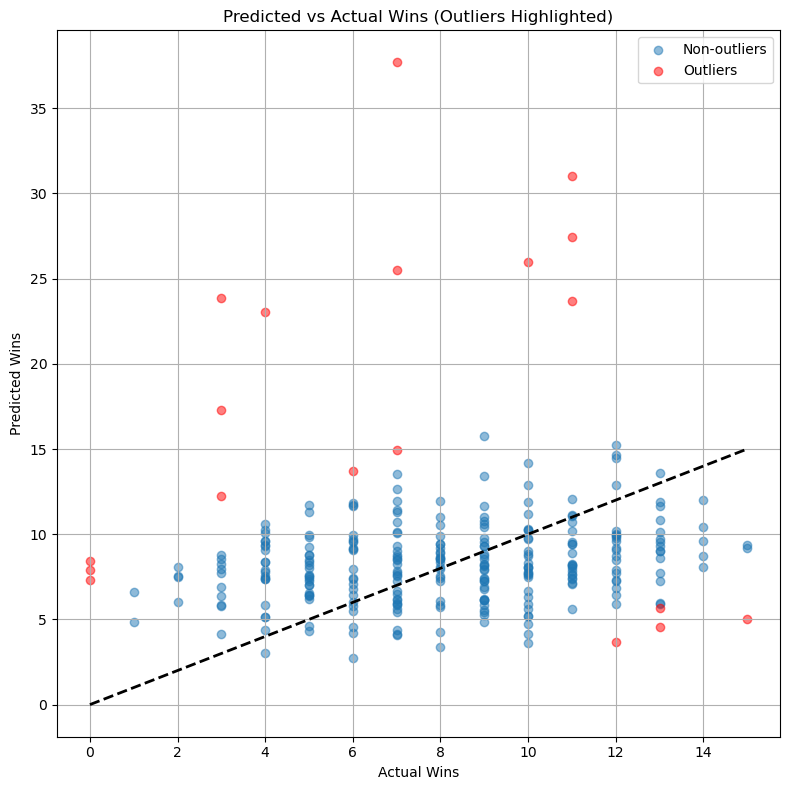

In [ ]:
# Identify and analyze outliers
residuals = np.array(all_y_pred) - np.array(all_y_test)
abs_residuals = np.abs(residuals)

# Define outliers as points with residuals > 2 standard deviations
std_residuals = np.std(residuals)
outlier_threshold = 1.5 * std_residuals
outlier_indices = np.where(abs_residuals > outlier_threshold)[0]

print(f"\nIdentified {len(outlier_indices)} outliers (residuals > {outlier_threshold:.2f}):")

# Create a list to store outlier information
outliers = []

# Print information about each outlier
for idx in outlier_indices:
    # Find the original index in the dataset
    original_idx = madden_data.index[idx]
    team = madden_data.iloc[original_idx]
    pred_wins = all_y_pred[idx]
    actual_wins = all_y_test[idx]
    residual = residuals[idx]
    
    print(f"  {team['team_name']} ({team['year']}): Predicted: {pred_wins:.1f}, Actual: {actual_wins}, Residual: {residual:.1f}")
    
    # Store outlier information
    outliers.append({
        'team': team['team_name'],
        'year': team['year'],
        'predicted': pred_wins,
        'actual': actual_wins,
        'residual': residual
    })

# Calculate R² without outliers
non_outlier_indices = np.setdiff1d(np.arange(len(all_y_test)), outlier_indices)
y_test_no_outliers = np.array(all_y_test)[non_outlier_indices]
y_pred_no_outliers = np.array(all_y_pred)[non_outlier_indices]

# Calculate R² without outliers
r2_no_outliers = r2_score(y_test_no_outliers, y_pred_no_outliers)
print(f"\nR² after removing outliers: {r2_no_outliers:.4f} (compared to {avg_r2:.4f} with outliers)")

# Scatter plot without outliers
plt.figure(figsize=(8, 8))
plt.scatter(y_test_no_outliers, y_pred_no_outliers, alpha=0.5, label='Non-outliers')
plt.scatter(np.array(all_y_test)[outlier_indices], np.array(all_y_pred)[outlier_indices], 
            alpha=0.5, color='red', label='Outliers')
plt.plot([min(all_y_test), max(all_y_test)], [min(all_y_test), max(all_y_test)], 'k--', lw=2)
plt.xlabel('Actual Wins')
plt.ylabel('Predicted Wins')
plt.title('Predicted vs Actual Wins (Outliers Highlighted)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Explanation of Outlier for each team (courtesy of Chat-GPT)

🏈 Las Vegas Raiders (2016)
The Raiders clinched a playoff berth for the first time since 2002, ending a 14-year drought.

Quarterback Derek Carr led multiple game-winning drives during the season.

The team finished with a 12-4 record but lost in the Wild Card round to the Houston Texans. ​
Wikipedia
Las Vegas Raiders
Las Vegas Raiders

🏈 Denver Broncos (2020)
In a unique situation, all Broncos quarterbacks were unavailable due to COVID-19 protocols, forcing practice squad wide receiver Kendall Hinton to start at quarterback against the Saints. ​
Diario AS

🏈 Los Angeles Rams (2020)
The Rams released star running back Todd Gurley to avoid a $10.5 million bonus payment.

They also released linebacker Clay Matthews and sought to trade wide receiver Brandin Cooks to free up salary cap space. ​
SI
+3
Diario AS
+3
Official Site of the Los Angeles Rams
+3

🏈 New Orleans Saints (2023)
The Saints had a challenging season, finishing with a 5-12 record and placing third in the NFC South. ​
ESPN.com

🏈 New England Patriots (2015)
The "Deflategate" scandal dominated headlines, with the NFL finding it "more probable than not" that Patriots personnel deflated footballs during the AFC Championship Game.

As a result, the Patriots were fined $1 million, lost two draft picks, and quarterback Tom Brady was suspended for four games. ​
talkSPORT
+2
The Guardian
+2
Time
+2
talkSPORT

🏈 Chicago Bears (2019)
Offensive lineman Kyle Long was reportedly ejected from practice after a fight with a rookie defensive lineman.

Rookie running back David Montgomery had a solid debut season after being selected in the third round of the draft. ​
Fox News
Chicago Bears

🏈 Chicago Bears (2017)
The Bears made a surprising move in the draft, trading four picks to move up one spot and select quarterback Mitchell Trubisky with the No. 2 overall pick. ​
CBSSports.com

🏈 Minnesota Vikings (2017)
The Vikings had a standout season, finishing with a 13-3 record and a strong rushing attack, even after losing rookie Dalvin Cook to injury in Week 4.

They also honored former players Randy Moss and Ahmad Rashad by inducting them into the team's Ring of Honor. ​
Daily Norseman
Minnesota Vikings

🏈 Arizona Cardinals (2019)
Under new head coach Kliff Kingsbury and rookie quarterback Kyler Murray, the Cardinals had the NFL's most improved offense, setting a franchise record by averaging 5.03 yards per carry. ​
Arizona Cardinals

🏈 Pittsburgh Steelers (2020)
The Steelers started the season 11-0 but faced challenges later in the year, including a loss to the Washington Football Team that ended their unbeaten streak. ​

🏈 Indianapolis Colts (2024)
The Colts faced a disappointing season, finishing with a 4-13 record and being eliminated from playoff contention after a loss to the New York Giants. ​
Big Blue View

Best alpha value: 0.3727593720314942
Training MSE: 8.91
Testing MSE: 8.24
Training R²: 0.16
Testing R²: 0.06


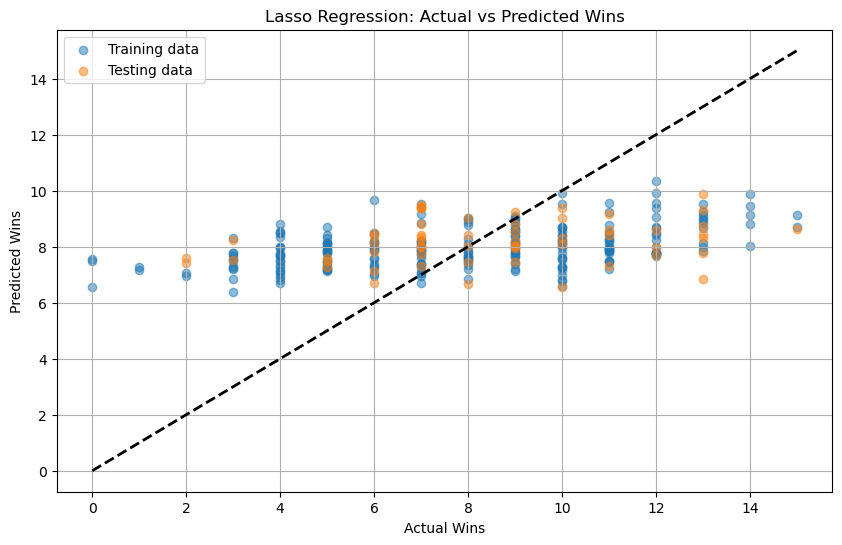

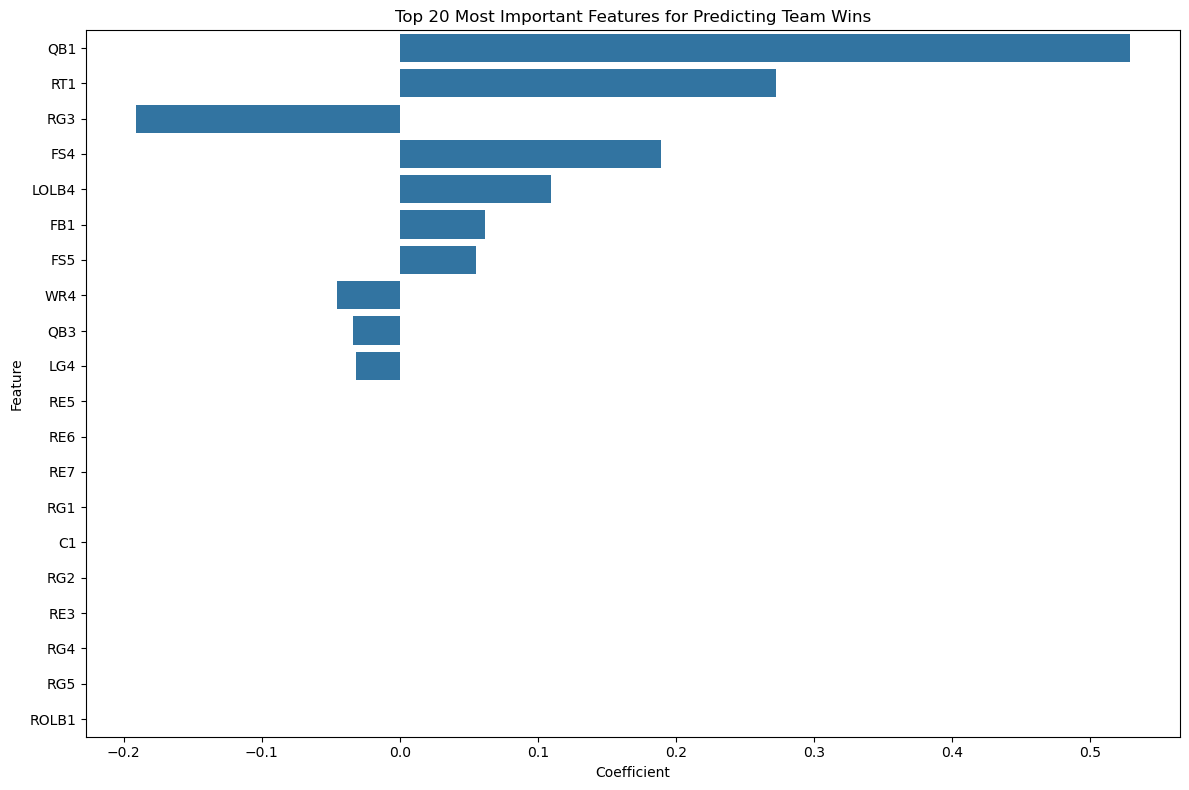

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

# Load the team data
# Assuming the data is already loaded in a previous cell
# If not, you would need to load it with something like:
# team_data = pd.read_csv('path_to_team_data.csv')

# Let's create a Lasso regression model to predict team wins

# First, separate features and target
X = madden_data.drop(['team_name', 'year', 'regular_season_wins', 'playoff_wins', 'total_wins'], axis=1)
y = madden_data['total_wins']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the Lasso model with cross-validation to find the best alpha
param_grid = {'alpha': np.logspace(-4, 1, 50)}
lasso_cv = GridSearchCV(Lasso(max_iter=10000, random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')
lasso_cv.fit(X_train_scaled, y_train)

# Get the best alpha value
best_alpha = lasso_cv.best_params_['alpha']
print(f"Best alpha value: {best_alpha}")

# Train the final model with the best alpha
lasso_model = Lasso(alpha=best_alpha, max_iter=10000, random_state=42)
lasso_model.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred = lasso_model.predict(X_train_scaled)
y_test_pred = lasso_model.predict(X_test_scaled)

# Evaluate the model
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Training MSE: {train_mse:.2f}")
print(f"Testing MSE: {test_mse:.2f}")
print(f"Training R²: {train_r2:.2f}")
print(f"Testing R²: {test_r2:.2f}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_train_pred, alpha=0.5, label='Training data')
plt.scatter(y_test, y_test_pred, alpha=0.5, label='Testing data')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Wins')
plt.ylabel('Predicted Wins')
plt.title('Lasso Regression: Actual vs Predicted Wins')
plt.legend()
plt.grid(True)
plt.show()

# Identify the most important features
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lasso_model.coef_
})
feature_importance = feature_importance.sort_values(by='Coefficient', key=abs, ascending=False)

# Plot the top 20 most important features
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(20)
sns.barplot(x='Coefficient', y='Feature', data=top_features)
plt.title('Top 20 Most Important Features for Predicting Team Wins')
plt.tight_layout()
plt.show()


Model Evaluation with 5-fold Cross-Validation:
--------------------------------------------------
Linear Regression:
  RMSE: 4.95 (±0.64)
  R²: -1.41 (±0.67)
--------------------------------------------------
Ridge Regression:
  RMSE: 4.69 (±0.58)
  R²: -1.16 (±0.57)
--------------------------------------------------
Lasso Regression:
  RMSE: 3.13 (±0.27)
  R²: 0.06 (±0.03)
--------------------------------------------------
ElasticNet:
  RMSE: 3.32 (±0.25)
  R²: -0.08 (±0.18)
--------------------------------------------------
Random Forest:
  RMSE: 3.07 (±0.26)
  R²: 0.10 (±0.05)
--------------------------------------------------
Gradient Boosting:
  RMSE: 3.24 (±0.20)
  R²: -0.02 (±0.11)
--------------------------------------------------
SVR:
  RMSE: 3.22 (±0.27)
  R²: 0.01 (±0.04)
--------------------------------------------------

Models Ranked by R² Score:
                         R²      RMSE
Random Forest      0.098667  3.065646
Lasso Regression   0.062363  3.128456
SVR          

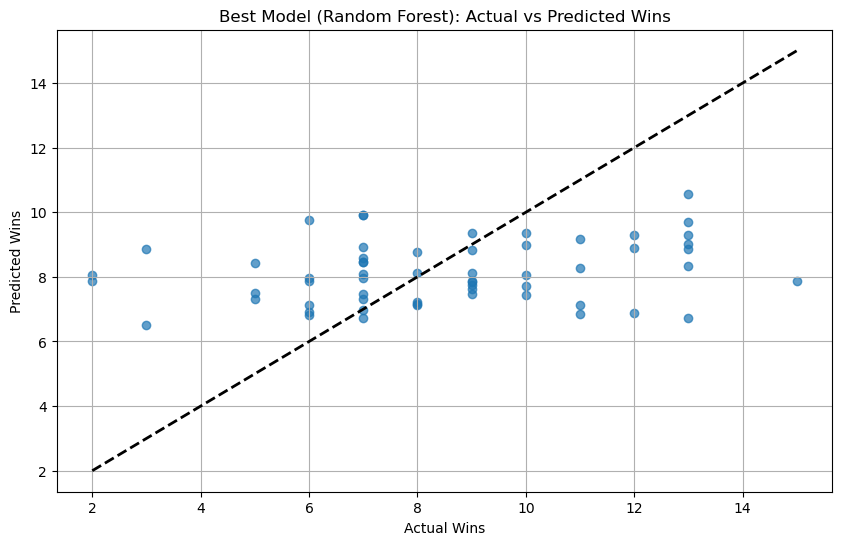

In [27]:
# Try multiple regression models and compare their performance

# Import necessary libraries
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
import numpy as np

# Define the models to evaluate
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'Lasso Regression': Lasso(alpha=best_alpha, random_state=42),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=200, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=200, random_state=42),
    'SVR': SVR(kernel='rbf', C=1.0, epsilon=0.1)
}

# Evaluate each model using cross-validation
print("Model Evaluation with 5-fold Cross-Validation:")
print("-" * 50)

results = {}
for name, model in models.items():
    # Use negative mean squared error as scoring metric (higher is better)
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-cv_scores)
    r2_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
    
    # Store results
    results[name] = {
        'RMSE': rmse_scores.mean(),
        'RMSE_std': rmse_scores.std(),
        'R²': r2_scores.mean(),
        'R²_std': r2_scores.std()
    }
    
    print(f"{name}:")
    print(f"  RMSE: {rmse_scores.mean():.2f} (±{rmse_scores.std():.2f})")
    print(f"  R²: {r2_scores.mean():.2f} (±{r2_scores.std():.2f})")
    print("-" * 50)

# Convert results to DataFrame for easier comparison
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('R²', ascending=False)

# Display the sorted results
print("\nModels Ranked by R² Score:")
print(results_df[['R²', 'RMSE']])

# Train the best model on the full training set
best_model_name = results_df.index[0]
best_model = models[best_model_name]
best_model.fit(X_train_scaled, y_train)

# Evaluate the best model on the test set
y_pred_best = best_model.predict(X_test_scaled)
best_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))
best_test_r2 = r2_score(y_test, y_pred_best)

print(f"\nBest Model: {best_model_name}")
print(f"Test RMSE: {best_test_rmse:.2f}")
print(f"Test R²: {best_test_r2:.2f}")

# Plot actual vs predicted for the best model
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Wins')
plt.ylabel('Predicted Wins')
plt.title(f'Best Model ({best_model_name}): Actual vs Predicted Wins')
plt.grid(True)
plt.show()
